In [2]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
json_path = "/content/drive/MyDrive/pract3Landmrks/labelsejer1.json"
with open(json_path, 'r') as f:
    data = json.load(f)


def calculate_angle(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)

    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(np.degrees(radians))

    return angle if angle <= 180 else 360 - angle

def extract_features(frame_data):
    features = []

    left_arm = frame_data['pose']['left_arm']
    left_elbow_angle = calculate_angle(left_arm[0], left_arm[1], left_arm[2])
    features.append(left_elbow_angle)


    right_arm = frame_data['pose']['right_arm']
    right_elbow_angle = calculate_angle(right_arm[0], right_arm[1], right_arm[2])
    features.append(right_elbow_angle)

    if len(frame_data['hands']) > 0:
        hand = frame_data['hands'][0]
        thumb_tip = hand[4][:2]
        index_tip = hand[8][:2]
        finger_distance = np.linalg.norm(np.array(thumb_tip) - np.array(index_tip))
        features.append(finger_distance)
    else:
        features.append(0.0)

    return features

In [ ]:
X = []
y = []
max_frames = 0  # Para padding posterior

for video_name, frames in data.items():
    video_features = []
    for frame in frames:
        video_features.append(extract_features(frame))
    X.append(video_features)
    y.append(frame['label'])  # Asumimos misma etiqueta para todo el video

    if len(video_features) > max_frames:
        max_frames = len(video_features)

# Padding para igualar longitud de secuencias
X_padded = pad_sequences(
    X,
    maxlen=max_frames,
    dtype='float32',
    padding='post',
    truncating='post'
)

In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Dividir dataset
X_train, X_temp, y_train, y_temp = train_test_split(
    X_padded, y_categorical,
    test_size=0.3,
    stratify=y_encoded
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=label_encoder.transform([label_encoder.inverse_transform(np.argmax(y_temp, axis=1))][0])
)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking

n_features = X_train.shape[2]
n_classes = y_categorical.shape[1]

model = Sequential([
    Masking(mask_value=0., input_shape=(max_frames, n_features)),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience= 15,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2857 - loss: 1.1039 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 1.0748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3810 - loss: 1.0876 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 1.0863 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4762 - loss: 1.0754 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 1.0981 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step - accuracy: 0.4286 - loss: 1.0634 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.1108 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4286 - loss: 1.0803 - precision: 0.0000e+00

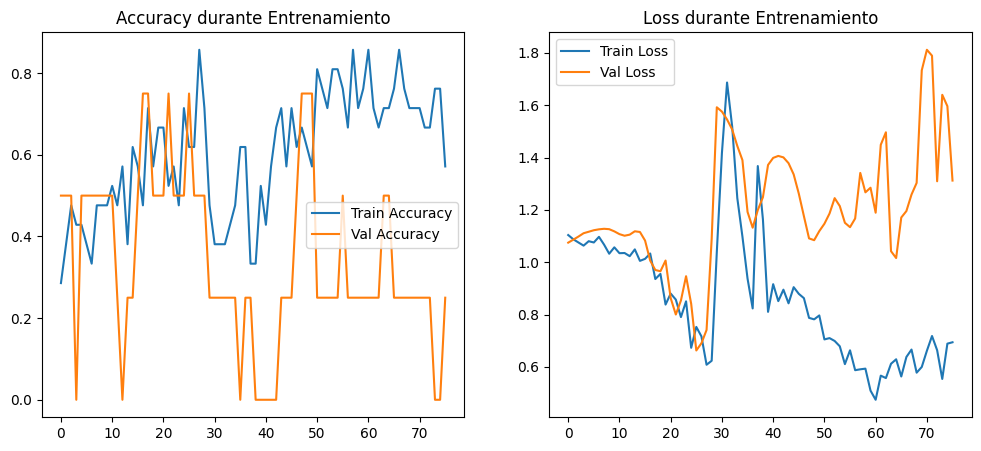

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step

Classification Report:
              precision    recall  f1-score   support

        full       0.33      1.00      0.50         1
        none       1.00      1.00      1.00         2
     partial       0.00      0.00      0.00         2

    accuracy                           0.60         5
   macro avg       0.44      0.67      0.50         5
weighted avg       0.47      0.60      0.50         5



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


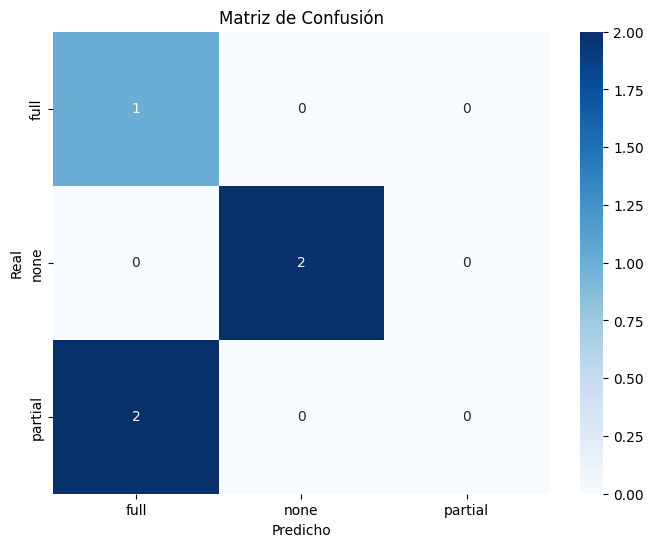

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Gráficas de entrenamiento
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy durante Entrenamiento')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss durante Entrenamiento')
plt.legend()
plt.show()

# Evaluación en test
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

# Matriz de confusión
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()


## Funcion para predicción en nuevos videos

In [ ]:
def predict_exercise(new_video_json):
    # Preprocesar igual que los datos de entrenamiento
    processed_data = []
    for frame in new_video_json:
        processed_data.append(extract_features(frame))

    # Aplicar padding
    padded_data = pad_sequences([processed_data], maxlen=max_frames, dtype='float32', padding='post')

    # Predecir
    prediction = model.predict(padded_data)
    predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])
    confidence = np.max(prediction)

    return predicted_class[0], confidence

In [ ]:
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils

def plot_landmarks(frame_data):
    # Convertir datos a formato MediaPipe
    pose_landmarks = mp.solutions.pose.PoseLandmark
    hand_landmarks = mp.solutions.hands.HandLandmark

    # Crear objetos dummy para visualización
    mp_pose = mp.solutions.pose
    mp_hands = mp.solutions.hands

    # Dibujar landmarks (ejemplo para un frame)
    image = np.zeros((720, 1280, 3), dtype=np.uint8)  # Imagen negra de 1280x720

    # Dibujar pose
    pose_results = dummy_pose_process(frame_data['pose'])
    mp_drawing.draw_landmarks(
        image, pose_results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

    # Dibujar manos
    hand_results = dummy_hand_process(frame_data['hands'])
    if hand_results.multi_hand_landmarks:
        for hand_landmarks in hand_results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    plt.imshow(image)
    plt.axis('off')
    plt.show()


# Prueba con Modelo Random Forest SGBOOST

In [10]:
def extract_video_features(frames):
    features = {}


    elbow_angles = []
    for frame in frames:

        left_arm = frame['pose']['left_arm']
        left_angle = calculate_angle(
            left_arm[0],
            left_arm[1],
            left_arm[2]
        )
        elbow_angles.append(left_angle)


        right_arm = frame['pose']['right_arm']
        right_angle = calculate_angle(
            right_arm[0],
            right_arm[1],
            right_arm[2]
        )
        elbow_angles.append(right_angle)


    features['max_elbow_angle'] = np.max(elbow_angles)
    features['min_elbow_angle'] = np.min(elbow_angles)
    features['mean_elbow_angle'] = np.mean(elbow_angles)


    return features

In [7]:
import numpy as np


def calculate_angle(a, b, c):

    a = np.array(a[:2])
    b = np.array(b[:2])
    c = np.array(c[:2])


    ba = a - b
    bc = c - b


    dot_product = np.dot(ba, bc)
    mag_ba = np.linalg.norm(ba)
    mag_bc = np.linalg.norm(bc)


    cosine_angle = dot_product / (mag_ba * mag_bc + 1e-10)
    angle = np.degrees(np.arccos(np.clip(cosine_angle, -1, 1)))

    return angle


def calculate_shoulder_angle(hip, shoulder, wrist):
    return calculate_angle(hip, shoulder, wrist)


def extract_video_features(frames):
    features = {}

    # 1. Ángulos del codo
    elbow_angles = []
    for frame in frames:

        left_arm = frame['pose']['left_arm']
        left_angle = calculate_angle(left_arm[0], left_arm[1], left_arm[2])
        elbow_angles.append(left_angle)


        right_arm = frame['pose']['right_arm']
        right_angle = calculate_angle(right_arm[0], right_arm[1], right_arm[2])
        elbow_angles.append(right_angle)

    features['max_elbow_angle'] = np.max(elbow_angles)
    features['min_elbow_angle'] = np.min(elbow_angles)
    features['mean_elbow_angle'] = np.mean(elbow_angles)


    shoulder_angles = []
    for frame in frames:

        hip = [0.5, 0.9]
        shoulder = frame['pose']['left_arm'][0][:2]
        wrist = frame['pose']['left_arm'][2][:2]
        angle = calculate_shoulder_angle(hip, shoulder, wrist)
        shoulder_angles.append(angle)

    features['shoulder_rom'] = np.max(shoulder_angles) - np.min(shoulder_angles)



    return features

In [8]:
import pandas as pd


with open('/content/drive/MyDrive/pract3Landmrks/labelsejer1.json', 'r') as f:
    data = json.load(f)


X = []
y = []
for video_name, frames in data.items():
    features = extract_video_features(frames)
    X.append(features)
    y.append(frames[0]['label'])


df = pd.DataFrame(X)
df['label'] = y

In [9]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler


X = df.drop('label', axis=1)
y = df['label']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y)


models = {
    'SVM': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': GradientBoostingClassifier()
}


param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(SVC(), param_grid, cv=3)
grid_search.fit(X_train, y_train)


best_model = grid_search.best_estimator_


y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        full       0.50      0.50      0.50         2
        none       0.67      1.00      0.80         2
     partial       1.00      0.50      0.67         2

    accuracy                           0.67         6
   macro avg       0.72      0.67      0.66         6
weighted avg       0.72      0.67      0.66         6

